Importing necessary libraries

In [23]:
import os
import numpy as np
import pandas as pd

# visuals
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense,MaxPooling2D,Dropout,Flatten,BatchNormalization,Conv2D
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping

In [ ]:
from google.colab import files

# Upload the training ZIP file
uploaded_train = files.upload()

# Upload the testing ZIP file
uploaded_test = files.upload()


Saving train.zip to train.zip


Saving test.zip to test.zip


In [ ]:
import zipfile
import os

# Define the paths for training and testing directories
train_zip_path = "/content/train.zip"
test_zip_path = "/content/test.zip"
files="collab/data"


# Extract the training ZIP file
with zipfile.ZipFile(train_zip_path, 'r') as zipp:
   zipp.extractall(files)

# Extract the testing ZIP file
with zipfile.ZipFile(test_zip_path, 'r') as zipp:
  zipp.extractall(files)


In [42]:
image_dir = "/content/collab/data/train"

filenames = os.listdir(image_dir)
labels = [x.split(" ")[0]for x in filenames]

data = pd.DataFrame({"filename": filenames, "label": labels})

data.head()

,filename,label
0,cat (133).jpg,cat
1,dogs (68).jpg,dogs
2,dogs (259).jpg,dogs
3,cat (175).jpg,cat
4,cat (218).jpg,cat


In [47]:
from sklearn.model_selection import train_test_split

X_train, X_temp = train_test_split(data, test_size=0.2, random_state=42)
X_test, X_val = train_test_split(X_temp, test_size=0.5, random_state=42)

print('The shape of train data', X_train.shape)
print('The shape of test data', X_test.shape)
print('The shape of validation data', X_val.shape)


The shape of train data (445, 2)
The shape of test data (56, 2)
The shape of validation data (56, 2)


In [49]:
train_datagen = ImageDataGenerator(rescale=1/255,
                                    horizontal_flip = True,
                                    zoom_range = 0.2,
                                    shear_range = 0.1)

test_datagen = ImageDataGenerator(rescale=1/255)

In [61]:
image_size=150
train_generator = train_datagen.flow_from_dataframe(X_train,
                                                    directory = '/content/collab/data/train',
                                                    x_col= 'filename',
                                                    y_col= 'label',
                                                    batch_size = 32,
                                                    target_size = (image_size,image_size)
                                                   )
val_generator = test_datagen.flow_from_dataframe(X_val,
                                                 directory = '/content/collab/data/train',
                                                 x_col= 'filename',
                                                 y_col= 'label',
                                                 batch_size = 32,
                                                 target_size = (image_size,image_size),
                                                 shuffle=False
                                                )

test_generator = test_datagen.flow_from_dataframe(X_test,
                                                  directory = '/content/collab/data/train',
                                                  x_col= 'filename',
                                                  y_col= 'label',
                                                  batch_size =32,
                                                  target_size = (image_size,image_size),
                                                  shuffle=False
                                                 )

Found 445 validated image filenames belonging to 3 classes.
Found 56 validated image filenames belonging to 2 classes.
Found 56 validated image filenames belonging to 2 classes.


In [69]:
model = Sequential()

# Input Layer
model.add(Conv2D(32,(3,3),activation='relu',input_shape = (150,150,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

# layer1
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
# layer2
model.add(Conv2D(128,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
# layer3
model.add(Conv2D(256,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(1,activation='sigmoid'))


In [70]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [34]:
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_accuracy',
                                            patience=2,
                                            factor=0.5,
                                            min_lr = 0.00001,
                                            verbose = 1)

early_stoping = EarlyStopping(monitor='val_loss',patience= 3,restore_best_weights=True,verbose=0)

In [74]:
cat_dog = model.fit(train_generator,
                    validation_data = val_generator,
                    epochs = 10,callbacks=[early_stoping,learning_rate_reduction],
                     steps_per_epoch = len(train_generator),
                     validation_steps = len(val_generator),
                   )

Epoch 1/10
14/14 [==============================] - 37s 3s/step - loss: 0.6793 - accuracy: 0.6352 - val_loss: 0.7775 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/10
14/14 [==============================] - 41s 3s/step - loss: 0.6711 - accuracy: 0.6390 - val_loss: 0.9794 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/10
14/14 [==============================] - ETA: 0s - loss: 0.6727 - accuracy: 0.6352
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
14/14 [==============================] - 39s 3s/step - loss: 0.6727 - accuracy: 0.6352 - val_loss: 0.7562 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 4/10
14/14 [==============================] - 38s 3s/step - loss: 0.6652 - accuracy: 0.6449 - val_loss: 0.6938 - val_accuracy: 0.5000 - lr: 5.0000e-04
Epoch 5/10
14/14 [==============================] - ETA: 0s - loss: 0.6716 - accuracy: 0.6375
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
14/14 [==============================] - 38s 3s/step - 

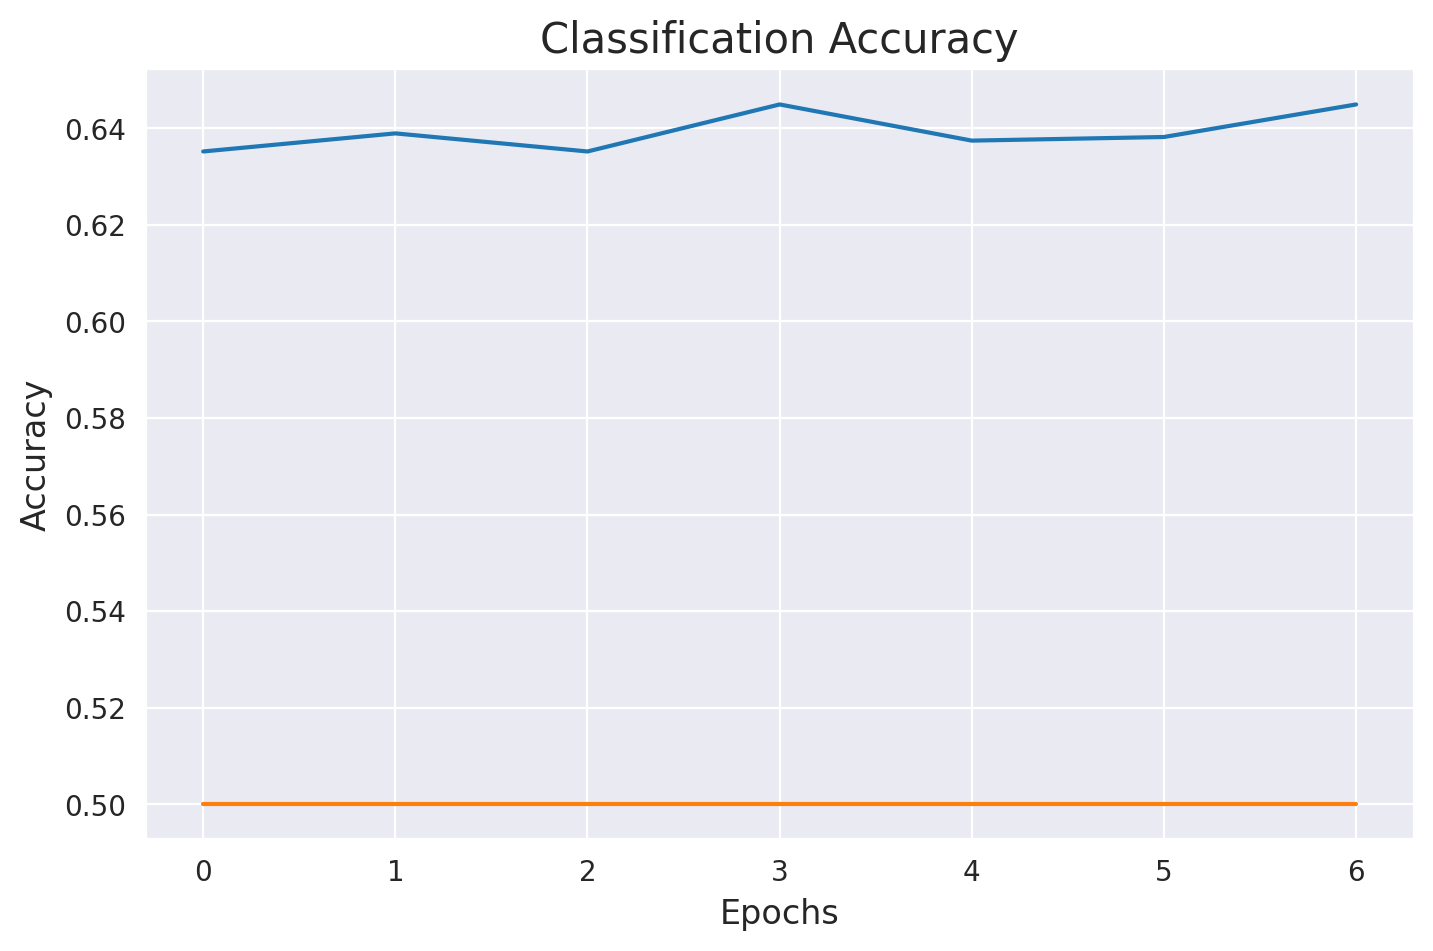

In [75]:
error = pd.DataFrame(cat_dog.history)

plt.figure(figsize=(18,5),dpi=200)
sns.set_style('darkgrid')

plt.subplot(122)
plt.title('Classification Accuracy',fontsize=15)
plt.xlabel('Epochs',fontsize=12)
plt.ylabel('Accuracy',fontsize=12)
plt.plot(error['accuracy'])
plt.plot(error['val_accuracy'])

plt.show()

In [80]:
# Evaluvate for train generator
loss,acc = model.evaluate(train_generator,batch_size = 32,)

print('The accuracy of the model for training data is:',acc*100)
print('The Loss of the model for training data is:',loss)

# Evaluvate for validation generator
loss,acc = model.evaluate(val_generator,batch_size =32,)

print('The accuracy of the model for validation data is:',acc*100)
print('The Loss of the model for validation data is:',loss)

14/14 [==============================] - 15s 1s/step - loss: 0.6885 - accuracy: 0.5521
The accuracy of the model for training data is: 55.205994844436646
The Loss of the model for training data is: 0.6884880661964417
2/2 [==============================] - 1s 361ms/step - loss: 0.6938 - accuracy: 0.5000
The accuracy of the model for validation data is: 50.0
The Loss of the model for validation data is: 0.6937962770462036


In [78]:
result = model.predict(test_generator,batch_size = 32)

y_pred = np.argmax(result, axis = 1)

y_true = test_generator.labels

# Evaluvate
loss,acc = model.evaluate(test_generator, batch_size =32)

print('The accuracy of the model for testing data is:',acc*100)
print('The Loss of the model for testing data is:',loss)

2/2 [==============================] - 2s 514ms/step - loss: 0.6937 - accuracy: 0.5000
The accuracy of the model for testing data is: 50.0
The Loss of the model for testing data is: 0.6937081217765808
